In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_start = dt.date(2018, 8, 1)
trip_end = dt.date(2018, 8, 7)

data = calc_temps(trip_start-dt.timedelta(days=365), trip_end-dt.timedelta(days=365))
print(data)

[(72.0, 79.25, 83.0)]


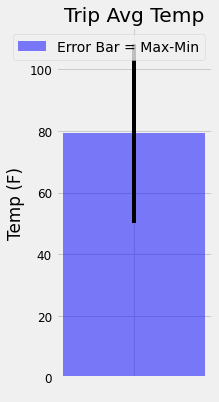

In [56]:
# Plot the results from your previous query as a bar chart. 
bar_df = pd.DataFrame(data=data, columns=["tmin", "tavg", "tmax"])
# Use "Trip Avg Temp" as your Title
plot_tmin = bar_df['tmin']
plot_tavg = bar_df['tavg']
plot_tmax = bar_df['tmax']

# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
diff = bar_trip_df['tmax'] - bar_trip_df['tmin']

plt.figure(figsize=[2.5, 6])

pavg = plt.bar(' ',plot_tavg, yerr=diff, color="blue", alpha=.5, label="Error Bar = Max-Min")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.legend()
plt.yticks(np.arange(0, 120, 20), fontsize=12)
plt.savefig("Bar_Trip_Avg_Temp.png")
plt.show()




### Daily Rainfall Average

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.latitude,
                  Station.longitude,
                  Station.elevation)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= trip_start)\
.filter(Measurement.date <= trip_end)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

# A nice layout to read the results
print (f"Historical Rainfall Per Weather Station - Descending order")
print(f"Trip Dates: {trip_start+dt.timedelta(days=365)} - {trip_end+dt.timedelta(days=365)}")
print(f"Most Recent Data Search Dates: {trip_start} - {trip_end}")
print()
for row in results:
    rain = "{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Latitude:  {row[3]}  \
    Longitude:  {row[4]}  Elevation:  {row[5]}")
    print()

Historical Rainfall Per Weather Station - Descending order
Trip Dates: 2018-08-01 - 2018-08-07
Most Recent Data Search Dates: 2017-08-01 - 2017-08-07

Station:  USC00516128
    Rainfall:  0.36  
    Location:  MANOA LYON ARBO 785.2, HI US
    Latitude:  21.3331      Longitude:  -157.8025  Elevation:  152.4

Station:  USC00514830
    Rainfall:  0.22  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Latitude:  21.5213      Longitude:  -157.8374  Elevation:  7.0

Station:  USC00519281
    Rainfall:  0.06  
    Location:  WAIHEE 837.5, HI US
    Latitude:  21.45167      Longitude:  -157.84888999999998  Elevation:  32.9

Station:  USC00519397
    Rainfall:  0.04  
    Location:  WAIKIKI 717.2, HI US
    Latitude:  21.2716      Longitude:  -157.8168  Elevation:  3.0

Station:  USC00519523
    Rainfall:  0.00  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Latitude:  21.33556      Longitude:  -157.71139  Elevation:  19.5



In [46]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end)
# Strip off the year and save a list of strings in the format %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')
normals = []
for trip_date in trip_mmdd:
    normals.append(*daily_normals(trip_date))
# and append the results to a list called `normals`.

In [48]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

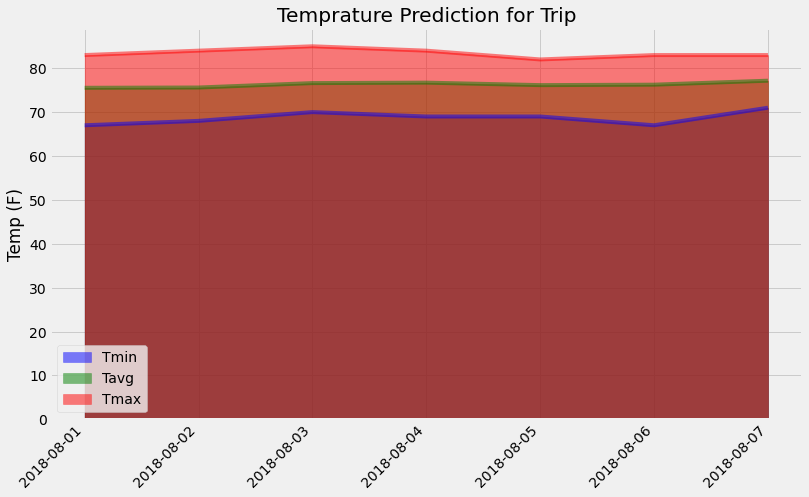

In [52]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['blue', 'green', 'red']

normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, alpha=.5, title='Temprature Prediction for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.savefig("Predicted_Temperatures_for_Trip.png")
plt.show()


## Close Session

In [53]:
session.close()